In [547]:
# ---------------------------------------------------------------*
# SEIS 764 Artificial Intelligence
# Assignment 3 : build a deep neural network for regression.
# auther: Yann Mulonda - October 15, 2021
# ---------------------------------------------------------------*
# Import the libraries needed
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [504]:
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/IA_764/concrete.csv')
data_customers = pd.read_csv('/content/drive/MyDrive/IA_764/customers.csv')
data_onlineStore = pd.read_csv('/content/drive/MyDrive/IA_764/onlineStore.csv')
dataset = pd.DataFrame(data)
dataset_c = data_customers
dataset_o = data_onlineStore

In [462]:
def datasetInfo(data):
  # show dataset info
  print(data.info())
  # show dataset info - describe dataset
  print(data.describe())
  # show dataset info - top 10 rows
  print(data.head(10))

def splitDataset(data, testSize):
  # Split the data into the features and the target 
  dataset = data.values 
  # Features
  x = dataset[:,0].reshape(-1,1)
  # Target 
  y = dataset[:,1]

  # using 70-30 train-test split.
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=testSize)

  numOfInstances, numOfFeatures = X_train.shape

  return x, y, X_train, X_test, y_train, y_test, numOfInstances, numOfFeatures

In [463]:
# -----------------------------------------------------------------------------*
# Part 1 : concrete dataset
# -----------------------------------------------------------------------------*
# datasetInfo(dataset)

In [464]:
# Split the data into the features and the target 
# using 70-30 train-test split.
split = splitDataset(dataset, 0.3)

# Features
x = split[0]
# Target 
y = split[1]

X_train = split[2]
X_test = split[3] 
y_train = split[4] 
y_test = split[5]

numOfInstance = split[6] 
numOfFeatures = split[7]

In [465]:
# plot the data set
# plt.scatter(x, y)

In [466]:
# Normalizing or standardization.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# we use transform here to avoid data leackage
X_test = scaler.transform(X_test)

print("x_train.shape:", X_train.shape)
print("x_test.shape:", X_test.shape)

x_train.shape: (721, 1)
x_test.shape: (309, 1)


In [467]:
#learning rate scheduler
def learning_rate_scheduler(epoch,lr):
  if epoch>=50:
    return 0.0001
  return 0.001

In [468]:
# let build the Regression model
def regressionModel(Xtrain, Xtest, ytrain, ytest, numFeatures, optimizer_value):
  model = tf.keras.models.Sequential()
  # Now lets define our Tensorflow model
  model.add(tf.keras.layers.Dense(units=1, 
                                  input_shape=[numFeatures], 
                                  activation='sigmoid')
            )

  # Specifying learning rate and momentum with desired optimizer
  if optimizer_value is 'SGD':
    opt_value= 'SGD'
  elif optimizer_value is 'Adam':
    opt_value= 'Adam'
  else:
    opt_value= 'RMSprop'
    
  model.compile(
        optimizer=opt_value, loss='binary_crossentropy', metrics=['accuracy']
        )

  # learning rate scheduler 
  # calling learning_rate_scheduler function 
  scheduler=tf.keras.callbacks.LearningRateScheduler(learning_rate_scheduler)
  
  # Train the model
  # Fit function has a parameter for batch_size. 
  # If unspecified batch_sizewill default to 32.
  # Run it for 100 epochs
  # 30% of thedata for validation - 0.3
  # r = model.fit(
  #     x,y, epochs=100, validation_split=0.3, verbose=0, callbacks=[scheduler]
  #     ) 
  r = model.fit(Xtrain, 
                ytrain, 
                validation_data=(Xtest, ytest), 
                epochs=100, 
                verbose=0,
                callbacks=[scheduler]
                )

  # Evaluate the model, loss and accuracy
  trainScore = model.evaluate(Xtrain, ytrain)
  testScore = model.evaluate(X_test, ytest)

  model_result = {
        "Train score": trainScore,
        "Test score": testScore,
    }

  # Make predictions
  # they are outputs of the sigmoid, interpreted as probabilities p(y = 1 | x)
  y_pred_1 = model.predict(X_test)
  # Round to get the actual predictions
  # Note: has to be flattened since the targets are size (N,) 
  # while the predictions are size (N,1)
  y_pred_2 = np.round(y_pred_1).flatten()

  # Calculate the accuracy, compare it to evaluate() output
  manuallyCalculatedAccuracy = np.mean(y_pred_2 == y_test)
  evaluateOutput = model.evaluate(X_test, y_test)

  predictions_result = {
      "y_pred -- outputs of the sigmoid": y_pred_1,
      "y_predictions": y_pred_2,
      "Manually calculated accuracy": manuallyCalculatedAccuracy,
      "Evaluate output": evaluateOutput
  }

  return model_result, r, predictions_result

In [469]:
# show result 
def show_result(Xtrain, Xtest, ytrain, ytest, numFeatures, optimizer):
  output = regressionModel(Xtrain, Xtest, ytrain, ytest, numFeatures, optimizer)[0]
  r = regressionModel(Xtrain, Xtest, ytrain, ytest, numFeatures, optimizer)[1]
  predictions = regressionModel(Xtrain, Xtest, ytrain, ytest, numFeatures, optimizer)[1]
  
  # Plot the loss
  plt.plot(r.history['loss'], label='loss')
  plt.plot(r.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()
  # Plot the accuracy 
  plt.plot(r.history['accuracy'], label='acc')
  plt.plot(r.history['val_accuracy'], label='val_acc')
  plt.legend()
  plt.show()

  print("{} {}".format(output, predictions))

In [470]:
# Adam optimizer
# show_result(X_train, X_test, y_train, y_test, numOfFeatures, 'Adam')

In [471]:
# SGD optimizer
# show_result(X_train, X_test, y_train, y_test, numOfFeatures, 'SGD')

In [472]:
# rmsprop optimizer
# show_result(X_train, X_test, y_train, y_test, numOfFeatures, 'RMSprop')

In [489]:
# -----------------------------------------------------------------------------*
# Part 2 : customers dataset
# -----------------------------------------------------------------------------*
# show dataset info
# datasetInfo(dataset_c)

def splitCustomerDataset(data, testSize):
  # Split the data into the features and the target 
  # Features
  x = data.iloc[:,3:13].values
  # Target 
  y = data.iloc[:,13].values

  #Label Encoding Gender
  labelencoder_X = LabelEncoder()
  x[:, 2] = labelencoder_X.fit_transform(x[:, 2])

  #Dealing with the categorical Geography column
  onehotencoder = make_column_transformer((OneHotEncoder(),
                                           [1]), 
                                          remainder='passthrough'
                                          )
  x = onehotencoder.fit_transform(x)

  #Removing the extra dummy variable
  x = x[:, 1:]

  # using 70-30 train-test split.
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=testSize)

  return x, y, X_train, X_test, y_train, y_test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Lastname         10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Left             10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None
         RowNumber    CustomerId  ...  EstimatedSalary          Left
count  10000.00000  

In [474]:
# Split the Customers data into the features and the target 
# using 70-30 train-test split.
split = splitCustomerDataset(dataset_c, 0.3)

# Features
x = split[0]
# Target 
y = split[1]

X_train = split[2]
X_test = split[3] 
y_train = split[4] 
y_test = split[5]

In [475]:
# Normalizing or standardization.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# we use transform here to avoid data leackage
X_test = scaler.transform(X_test)

print("x_train.shape:", X_train.shape)
print("x_test.shape:", X_test.shape)

x_train.shape: (7000, 11)
x_test.shape: (3000, 11)


In [476]:
# Build the model for customer data
# Define the model
model = tf.keras.models.Sequential()

#Adding a first layer 
model.add(tf.keras.layers.Dense(units=6, input_shape=[11], activation='relu'))
# model.add(tf.keras.layers.Dropout(0.1))
#Adding a second hidden layer
model.add(tf.keras.layers.Dense(units=6, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.1))

#Adding an output layer
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [477]:
# Train the model
r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)

# Evaluate the model, prints loss and accuracy
print("Train score:", model.evaluate(X_train, y_train))
print("Test score:", model.evaluate(X_test, y_test))

219/219 [==============================] - 0s 1ms/step - loss: 0.3310 - accuracy: 0.8599
Train score: [0.3309727609157562, 0.8598571419715881]
94/94 [==============================] - 0s 1ms/step - loss: 0.3359 - accuracy: 0.8633
Test score: [0.3359313905239105, 0.8633333444595337]


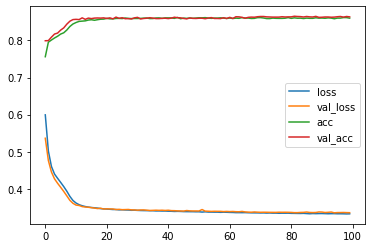

In [478]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [479]:
# Making predictions and evaluating the model
# Predicting the Test set results
y_pred = model.predict(X_test)

# perform prediction on the following customer:
# •Credit Score: 600 
# •Geography: France
# •Gender: Male
# •Age: 40 years old
# •Tenure: 3 years
# •Balance: $60000
# •Number of Products: 2
# •Does this customer have a credit card ? Yes
# •Is this customer an Active Member: Yes
# •Estimated Salary: $50000
customer_prediction = model.predict(scaler.transform(np.array([[0.0, 0, 600, 1, 40, 3, 60000, 2, 1, 1, 50000]])))

print("Predicting the Test set results: ", y_pred)
print("Customer Prediction: ", customer_prediction)

Predicting the Test set results:  [[0.08141151]
 [0.10205412]
 [0.01296899]
 ...
 [0.5269806 ]
 [0.05801788]
 [0.04955089]]
Customer Prediction:  [[0.03438199]]


In [480]:
#Confusion Matrix
# cm = confusion_matrix(y_test, y_pred)
# # cm = confusion_matrix(y_test, customer_prediction)
# print("               Predicted Label")
# print(cm)

In [549]:
def buildNN():
    # Define the model
    model = tf.keras.models.Sequential()

    #Adding an input layer and one hidden layer
    model.add(tf.keras.layers.Dense(units=6, input_shape=[11], activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))

    #Adding a second hidden layer
    model.add(tf.keras.layers.Dense(units=6, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))

    #Adding an output layer
    model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

classifier = KerasClassifier(build_fn = buildNN, batch_size=10, epochs=100)
accuracy = cross_val_score(estimator = classifier, X = X_train, y=y_train, cv=10, n_jobs=-1,verbose=3)

accuracy

meanAcc = accuracy.mean()
stdDevAcc = accuracy.std()

meanAcc

stdDevAcc


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.4s finished


nan

In [553]:
# Hyperparameter tuning of Neural Network
# def buildNN(optimizer):
#     model = tf.keras.models.Sequential()
#     model.add(tf.keras.layers.Dense(units=6, input_shape=[11], activation='relu'))
#     model.add(tf.keras.layers.Dropout(0.1))
#     model.add(tf.keras.layers.Dense(units=6, activation='relu'))
#     model.add(tf.keras.layers.Dropout(0.1))
#     model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     return model

# classifier = KerasClassifier(build_fn = buildNN)
# parameters = {'batch_size':[25,32], 'epochs':[100,500], 'optimizer':['adam','rmsprop']}
# grid_search = GridSearchCV(estimator =classifier, param_grid=parameters, scoring='accuracy', cv=10)
# grid_search = grid_search.fit(X_train, y_train)
# best_param = grid_search.best_params_
# best_acc=grid_search.best_score_

# print(best_param)
# print(best_acc)

In [562]:
# -----------------------------------------------------------------------------*
# Part 3 : OnlineStore dataset
# -----------------------------------------------------------------------------*
# show online Store dataset info
# datasetInfo(dataset_o)

def splitOnlineStoreDataset(data):
  # Split the data into the features and the target 
  # Features
  x = dataset_o.iloc[:, 0:5].values
  # Target 
  y = dataset_o.iloc[:, 5].values

  #Label Encoding Gender
  labelencoder_X = LabelEncoder()
  x[:, 4] = labelencoder_X.fit_transform(x[:, 4])

  # #Dealing with the categorical Geography column
  onehotencoder = make_column_transformer((OneHotEncoder(),
                                            [1]), 
                                          remainder='passthrough'
                                          )
  x = onehotencoder.fit_transform(x)

  # #Removing the extra dummy variable
  # x = x[:, 1:]

  # using 70-30 train-test split.
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

  return x, y, X_train, X_test, y_train, y_test

In [563]:
# # Split the Customers data into the features and the target 
split = splitOnlineStoreDataset(dataset_o)

# Features
x = split[0]
# Target 
y = split[1]

X_train = split[2]
X_test = split[3] 
y_train = split[4] 
y_test = split[5]

# Normalizing or standardization.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# we use transform here to avoid data leackage
X_test = scaler.transform(X_test)

print("x_train.shape:", X_train.shape)
print("x_test.shape:", X_test.shape)

x_train.shape: (350, 9)
x_test.shape: (150, 9)


In [566]:
# Define the model
model = tf.keras.models.Sequential()

#Adding a first layer 
model.add(tf.keras.layers.Dense(units=6, input_shape=[11], activation='relu'))
# model.add(tf.keras.layers.Dropout(0.1))
#Adding a second hidden layer
model.add(tf.keras.layers.Dense(units=6, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.1))

#Adding an output layer
model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
# r = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, verbose=0)

In [ ]:
# Note
# I really struggled with Part 3 and was not to complete the before the dealine 
# I'm doing addiotnal reading on the sectoion. Thanks!